In [1]:
import pandasql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import metrics

In [2]:
vg = pd.read_csv('vgsales.csv')

In [3]:
data_vg = vg

In [35]:
data_vg.head()

,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales
19,0,3,22,542,2049,20.32
20,0,3,23,542,2049,19.39
30,0,3,21,542,2049,16.15
32,0,3,35,542,2049,15.86
34,15,3,23,31,2534,15.09


Fields include:

    Rank - Ranking of overall sales
    Name - Name of the game
    Platform - Platform of the game (i.e. PC, PS4, XOne, etc.)
    Genre - Genre of the game
    ESRB Rating - ESRB Rating of the game
    Publisher - Publisher of the game
    Developer - Developer of the game
    Critic Score - Critic score of the game from 10
    User Score - Users score the game from 10
    Total Shipped - Total shipped copies of the game
    Global_Sales - Total worldwide sales (in millions)
    NA_Sales - Sales in North America (in millions)
    PAL_Sales - Sales in Europe (in millions)
    JP_Sales - Sales in Japan (in millions)
    Other_Sales - Sales in the rest of the world (in millions)
    Year - Year of release of the game


## Data Analysis Process<br>
Question - Wrangle - Explore - Conclusion - Communicate


**Question**

1. Perkembangan Genre Game dr tahun ke tahun
2. Perkembangan platform game dari tahun ke tahun
3. 5 Genre game yang paling banyak di buat
4. Developer yang paling banyak membuat game pada Question 3

**Wrangle**

In [5]:
#drop kolom yg banyak null values
data_vg = data_vg.drop(columns=['Critic_Score', 'User_Score','Total_Shipped','Global_Sales','NA_Sales','PAL_Sales','JP_Sales','Other_Sales','ESRB_Rating'])

In [6]:
#fill null values Developer
data_vg['Developer'] = data_vg['Developer'].fillna(data_vg['Developer'].mode()[0])

In [7]:
#fill null values Year
data_vg['Year'] = data_vg['Year'].fillna(data_vg['Year'].mode()[0])

In [9]:
data_vg['Year'] = data_vg['Year'].astype(int)

**Explore**

> 1. Perkembangan Genre Game dr tahun ke tahun

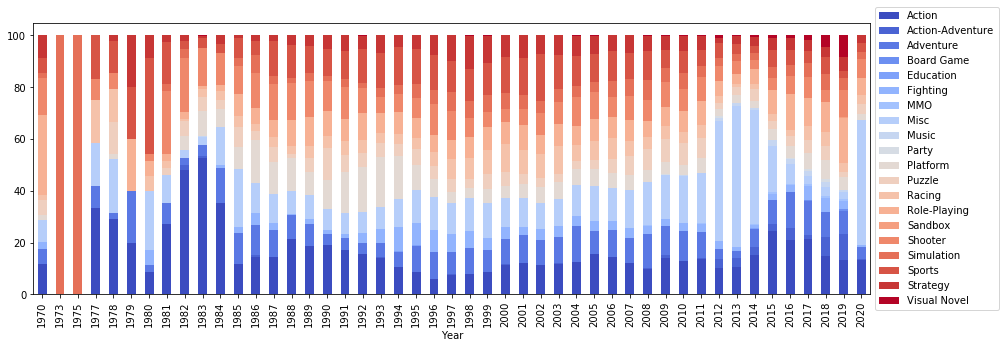

In [10]:
result_1 = data_vg.groupby(['Year','Genre'])['Rank'].count()\
            .groupby(level=0).apply(lambda x: 100 * x / float(x.sum())) \
            .unstack() 
result_1.plot.bar(figsize=(15,5), stacked=True, colormap='coolwarm')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

> 2. Perkembangan platform game dari tahun ke tahun

No handles with labels found to put in legend.


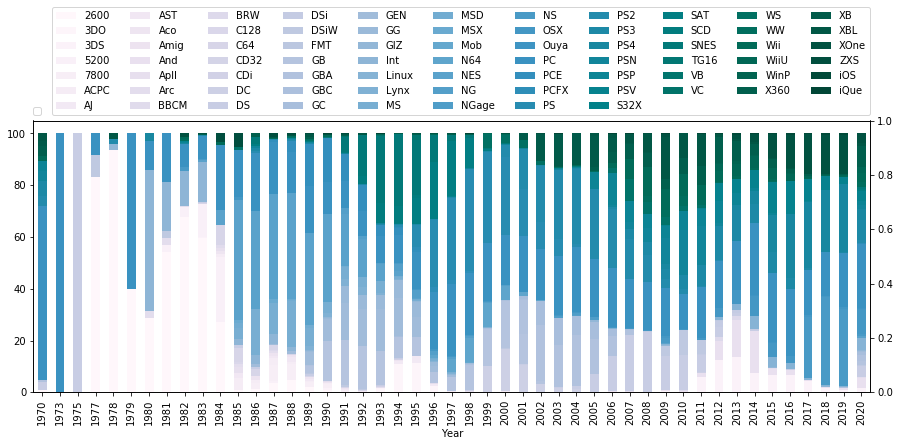

In [11]:
result_2 = data_vg.groupby(['Year','Platform'])['Rank'].count()\
            .groupby(level=0).apply(lambda x: 100 * x / float(x.sum())) \
            .unstack() 
result_2.plot.bar(figsize=(15,5), stacked=True, colormap='PuBuGn')
plt.legend(loc="lower right", bbox_to_anchor=(1., 1.02) , borderaxespad=0., ncol=11)
plt.twinx()
plt.legend(bbox_to_anchor=(0,1.02),loc="lower left", borderaxespad=0.)
plt.show()

> 3. 5 Genre game yang paling banyak di buat

In [12]:
result_3 = data_vg.groupby('Genre')['Rank'].count()\
            .sort_values(ascending=False)\
            .head()
result_3

Genre
Misc         9476
Action       7667
Adventure    5293
Sports       5244
Shooter      4586
Name: Rank, dtype: int64

> 4. Developer yang paling banyak membuat game pada Question 3

In [13]:
data_4 = data_vg[(data_vg['Genre']=='Misc') |(data_vg['Genre']=='Action') | (data_vg['Genre']=='Adventure') | (data_vg['Genre']=='Sports')| (data_vg['Genre']=='Shooter')]
result_4_raw = data_4.groupby(['Genre','Developer'],as_index=False)['Rank'].count()\
            .rename(columns={'Rank':'Jumlah'})
query = """
        SELECT
            a.Genre
            ,(
            SELECT max(b.Developer)
            FROM result_4_raw as b
            WHERE b.Genre = a.Genre
            ) as Developer
            ,(
            SELECT max(b.Jumlah)
            FROM result_4_raw as b
            WHERE b.Genre = a.Genre
            ) as Total
        FROM
            result_3 as a
        ORDER BY
            a.Rank desc
        LIMIT
            5
        """

result_4 = pandasql.sqldf(query)

result_4

,Genre,Developer,Total
0,Misc,zio3,4001
1,Action,yyr,436
2,Adventure,thechineseroom,147
3,Sports,thelostone,352
4,Shooter,xPox,95


**Conclusion**

1. Perkembangan Genre Game dr tahun ke tahun<br>
    setiap genre game mengalami kenaikan dan penurunan di setiap tahun memasuki thn 2020, tren genre game **Misc** mengalami kenaikan dari tahun sebelumnya, genre game **Action** tetap seperti tahun sebelumnya dan genre game lainnya mengalami penurunan
2. Perkembangan platform game dari tahun ke tahun<br>
    Memasuki tahun 2020, tren Platform yang naik dari tahun sebelumnya hanya **PC** sedangkan untuk Platform game lain mengalami penurunan
3. 5 Genre game yang paling banyak di buat<br>
    **Misc       9476<br>
    Action       7667<br>
    Adventure    5293<br>
    Sports       5244<br>
    Shooter      4586**<br>
4. Developer yang paling banyak membuat game pada Question 3<br>
    untuk Genre **Misc**, Developer **zio3** dengan jumlah **4001**<br>
    untuk Genre **Action**, Developer **yyr** dengan jumlah **436**<br>
    untuk Genre **Adventure**, Developer **thechineseroom** dengan jumlah **147**<br>
    untuk Genre **Sports**, Developer **thelostone** dengan jumlah **352**<br>
    untuk Genre **Shooter**, Developer **xPox** dengan jumlah **95**

## Maching Learning Process

In [14]:
data_vg = vg

**Questions**

prediksi Global Sales

**Wrangle**

In [15]:
#filter Global_Sales not null
data_vg = data_vg[pd.notnull(data_vg['Global_Sales'])]

In [16]:
#drop kolom yg banyak null values
data_vg = data_vg.drop(columns=['Rank','Name','Critic_Score', 'User_Score','Total_Shipped','Year','NA_Sales','PAL_Sales','JP_Sales','Other_Sales'])

In [17]:
#fill null values Developer
data_vg['Developer'] = data_vg['Developer'].fillna(data_vg['Developer'].mode()[0])

In [18]:
#fill null values ESRB Rating
data_vg['ESRB_Rating'] = data_vg['ESRB_Rating'].fillna(data_vg['ESRB_Rating'].mode()[0])

In [19]:
#one hot encoding Genre
# data_vg = pd.get_dummies(data_vg, columns=['Genre'])

#label encoding Genre
data_vg["Genre"] = data_vg["Genre"].astype('category')
data_vg["Genre"] = data_vg["Genre"].cat.codes

In [20]:
#one hot encoding ESRB_Rating
# data_vg = pd.get_dummies(data_vg, columns=['ESRB_Rating'])

#label encoding ESRB_Rating
data_vg["ESRB_Rating"] = data_vg["ESRB_Rating"].astype('category')
data_vg["ESRB_Rating"] = data_vg["ESRB_Rating"].cat.codes

In [21]:
#one hot encoding Platform
# data_vg = pd.get_dummies(data_vg, columns=['Platform'])

#label encoding Platform
data_vg["Platform"] = data_vg["Platform"].astype('category')
data_vg["Platform"] = data_vg["Platform"].cat.codes

In [22]:
#one hot encoding Publisher
# data_vg = pd.get_dummies(data_vg, columns=['Publisher'])

#label encoding Publisher
data_vg["Publisher"] = data_vg["Publisher"].astype('category')
data_vg["Publisher"] = data_vg["Publisher"].cat.codes

In [23]:
#one hot encoding Developer
# data_vg = pd.get_dummies(data_vg, columns=['Developer'])

#label encoding Developer
data_vg["Developer"] = data_vg["Developer"].astype('category')
data_vg["Developer"] = data_vg["Developer"].cat.codes

**Explore**

In [27]:
# Define parameters and labels
x = data_vg.drop(columns=['Global_Sales'])
y = data_vg['Global_Sales']

In [28]:
# Split the data into training data and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [29]:
# Initiate the model
model = LinearRegression()

In [30]:
# Training process
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
# Testing and evaluation process tanpa rounding global sales
y_pred = model.predict(x_test)
error = metrics.mean_absolute_error(y_test, y_pred)

print('MAE: {}'.format(error))

MAE: 0.3893022350727459
